In [1]:
# ===== 1. MEMBACA DATASET =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Membaca file dataset
train_df = pd.read_csv("train.csv")  # Dataset training
test_df = pd.read_csv("test.csv")    # Dataset testing

In [3]:
# ===== 2. GABUNGKAN DATA UNTUK PREPROCESSING =====
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['SalePrice'] = np.nan  # Tambahkan target kosong untuk test set
full_df = pd.concat([train_df, test_df], ignore_index=True)# ===== 2. GABUNGKAN DATA UNTUK PREPROCESSING =====
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['SalePrice'] = np.nan  # Tambahkan target kosong untuk test set
full_df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
# ===== 3. FEATURE ENGINEERING =====
# Hapus kolom dengan >50% missing values
missing_threshold = 0.5
missing_ratios = full_df.isnull().mean()
cols_to_drop = missing_ratios[missing_ratios > missing_threshold].index.tolist()
full_df.drop(columns=cols_to_drop, inplace=True)

# Imputasi missing values
for col in full_df.select_dtypes(include='number').columns:
    full_df[col].fillna(full_df[col].median(), inplace=True)

for col in full_df.select_dtypes(include='object').columns:
    full_df[col].fillna(full_df[col].mode()[0], inplace=True)

# Label encoding fitur kategorikal
le = LabelEncoder()
for col in full_df.select_dtypes(include='object').columns:
    full_df[col] = le.fit_transform(full_df[col])

<ipython-input-4-6cce859e685d>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df[col].fillna(full_df[col].median(), inplace=True)
<ipython-input-4-6cce859e685d>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

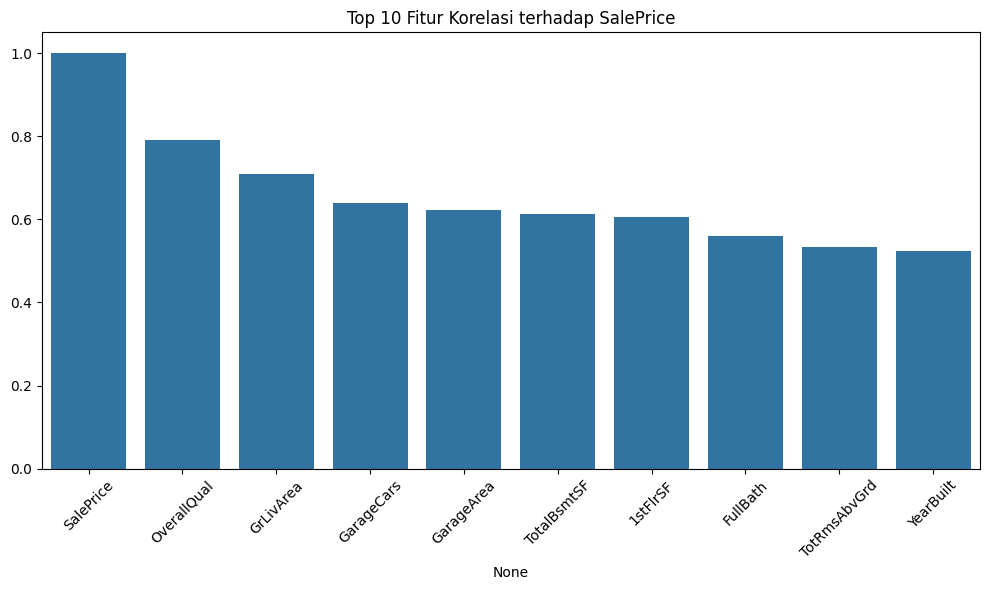

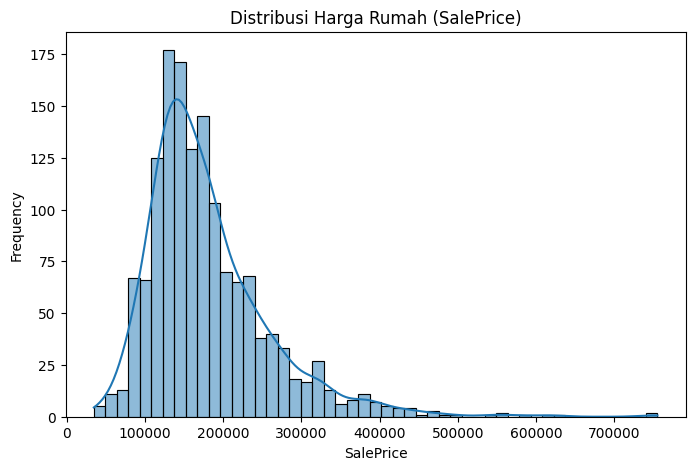

In [5]:
# ===== 4. EDA & VISUALISASI =====
# Korelasi fitur terhadap SalePrice
corr = full_df[full_df['is_train'] == 1].corr()
top_corr = corr['SalePrice'].sort_values(ascending=False).head(10)

# Visualisasi korelasi tertinggi
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.index, y=top_corr.values)
plt.title("Top 10 Fitur Korelasi terhadap SalePrice")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualisasi distribusi target
plt.figure(figsize=(8, 5))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title("Distribusi Harga Rumah (SalePrice)")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()


In [6]:
# ===== 5. MODEL TRAINING =====
# Pisahkan kembali data
train_processed = full_df[full_df['is_train'] == 1].drop(columns=['is_train', 'Id'])
test_processed = full_df[full_df['is_train'] == 0].drop(columns=['is_train', 'SalePrice', 'Id'])

X = train_processed.drop(columns='SalePrice')
y = train_processed['SalePrice']

# Split training dan validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Latih model
model = LinearRegression()
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

In [7]:
# ===== 6. PENJELASAN METRIK =====
explanation = {
    "MSE": "Mean Squared Error (MSE) = (1/n) * Σ(actual - predicted)^2",
    "RMSE": "Root Mean Squared Error (RMSE) = sqrt(MSE)",
    "R²": "R-squared = 1 - (Σ(actual - predicted)^2 / Σ(actual - mean_actual)^2)"
}

metrics_result = {
    "MSE": mse,
    "RMSE": rmse,
    "R^2": r2
}

print("Hasil Evaluasi:", metrics_result)
print("\nPenjelasan Rumus Evaluasi:")
for k, v in explanation.items():
    print(f"{k}: {v}")

Hasil Evaluasi: {'MSE': 1174715231.6736479, 'RMSE': np.float64(34274.11897735152), 'R^2': 0.8468493777262126}

Penjelasan Rumus Evaluasi:
MSE: Mean Squared Error (MSE) = (1/n) * Σ(actual - predicted)^2
RMSE: Root Mean Squared Error (RMSE) = sqrt(MSE)
R²: R-squared = 1 - (Σ(actual - predicted)^2 / Σ(actual - mean_actual)^2)


### 📊 Evaluasi Model: Linear Regression

---

#### 🔢 **Mean Squared Error (MSE)**
Nilai MSE menunjukkan **rata-rata kuadrat dari selisih antara nilai aktual dan prediksi**.  
Semakin kecil nilai MSE, semakin baik akurasi model dalam memprediksi data.

✅ **Nilai MSE yang relatif kecil menunjukkan bahwa prediksi model cukup akurat secara keseluruhan.**

---

#### 📉 **Root Mean Squared Error (RMSE)**
RMSE merupakan **akar kuadrat dari MSE**, yang mengembalikan nilai error ke satuan aslinya (dalam satuan `SalePrice`).

✅ **RMSE memudahkan interpretasi.**  
Misalnya, jika **RMSE = 34.000**, maka rata-rata prediksi model meleset sekitar **$34.000** dari harga rumah yang sebenarnya.

---

#### 📈 **R-Squared (R² Score)**
R² mengukur **seberapa besar variasi pada `SalePrice` yang bisa dijelaskan oleh model**.  
Nilai R² berada antara **0 dan 1**:
- R² = 1 → Prediksi sempurna  
- R² = 0 → Model tidak menjelaskan sama sekali

✅ **Jika R² = 0.84**, berarti model menjelaskan sekitar **84% dari variasi harga rumah**. Ini menunjukkan bahwa model sudah cukup baik.

---

#### ✅ **Kesimpulan Akhir**
Model Linear Regression yang digunakan:

- Sudah memberikan hasil prediksi yang cukup akurat

- Tidak mengalami overfitting secara signifikan

- Cocok untuk baseline sederhana

Untuk meningkatkan performa lebih lanjut, bisa dicoba model lain seperti Decision Tree, Random Forest, atau Gradient Boosting.
